## Rover Project Test Notebook
This notebook contains the functions from the lesson and provides the scaffolding you need to test out your mapping methods.  The steps you need to complete in this notebook for the project are the following:

* First just run each of the cells in the notebook, examine the code and the results of each.
* Run the simulator in "Training Mode" and record some data. Note: the simulator may crash if you try to record a large (longer than a few minutes) dataset, but you don't need a ton of data, just some example images to work with.   
* Change the data directory path (2 cells below) to be the directory where you saved data
* Test out the functions provided on your data
* Write new functions (or modify existing ones) to report and map out detections of obstacles and rock samples (yellow rocks)
* Populate the `process_image()` function with the appropriate steps/functions to go from a raw image to a worldmap.
* Run the cell that calls `process_image()` using `moviepy` functions to create video output
* Once you have mapping working, move on to modifying `perception.py` and `decision.py` to allow your rover to navigate and map in autonomous mode!

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

**Run the next cell to get code highlighting in the markdown cells.**

In [1]:
%%HTML
<style> code {background-color : orange !important;} </style>

In [2]:
%matplotlib inline
#%matplotlib qt # Choose %matplotlib qt to plot to an interactive window (note it may show up behind your browser)
# Make some of the relevant imports
import cv2 # OpenCV for perspective transform
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc # For saving images as needed
import glob  # For reading in a list of images from a folder
import imageio
imageio.plugins.ffmpeg.download()

## Quick Look at the Data
There's some example data provided in the `test_dataset` folder.  This basic dataset is enough to get you up and running but if you want to hone your methods more carefully you should record some data of your own to sample various scenarios in the simulator.  

Next, read in and display a random image from the `test_dataset` folder

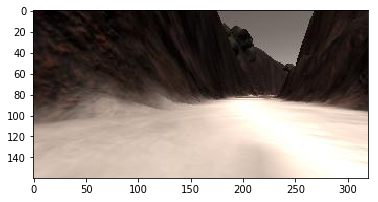

In [3]:
path = '../automode_img_data/IMG/*'
img_list = glob.glob(path)
# Grab a random image and display it
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
plt.imshow(image)

## Calibration Data
Read in and display example grid and rock sample calibration images.  You'll use the grid for perspective transform and the rock image for creating a new color selection that identifies these samples of interest. 

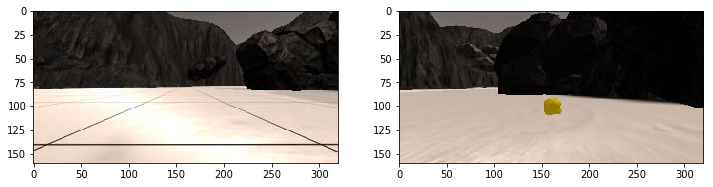

In [4]:
# In the simulator you can toggle on a grid on the ground for calibration
# You can also toggle on the rock samples with the 0 (zero) key.  
# Here's an example of the grid and one of the rocks
example_grid = '../calibration_images/example_grid1.jpg'
example_rock = '../calibration_images/example_rock1.jpg'
grid_img = mpimg.imread(example_grid)
rock_img = mpimg.imread(example_rock)

fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(grid_img)
plt.subplot(122)
plt.imshow(rock_img)

## Perspective Transform

Define the perspective transform function from the lesson and test it on an image.

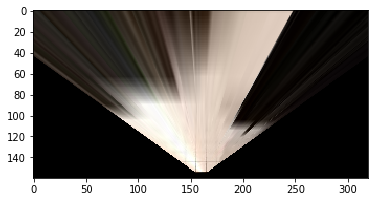

In [5]:
# Define a function to perform a perspective transform
# I've used the example grid image above to choose source points for the
# grid cell in front of the rover (each grid cell is 1 square meter in the sim)
# Define a function to perform a perspective transform
def perspect_transform(img, src, dst):
           
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))# keep same size as input image
    return warped


# Define calibration box in source (actual) and destination (desired) coordinates
# These source and destination points are defined to warp the image
# to a grid where each 10x10 pixel square represents 1 square meter
# The destination box will be 2*dst_size on each side
dst_size = 5 
# Set a bottom offset to account for the fact that the bottom of the image 
# is not the position of the rover but a bit in front of it
# this is just a rough guess, feel free to change it!
bottom_offset = 6
source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                  [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                  ])
warped = perspect_transform(grid_img, source, destination)
plt.imshow(warped)

scipy.misc.imsave('../output/warped_example.jpg', warped)


## Color Thresholding
Define the color thresholding function from the lesson and apply it to the warped image

**TODO:** Ultimately, you want your map to not just include navigable terrain but also obstacles and the positions of the rock samples you're searching for.  Modify this function or write a new function that returns the pixel locations of obstacles (areas below the threshold) and rock samples (yellow rocks in calibration images), such that you can map these areas into world coordinates as well.  
**Hints and Suggestion:** 
* For obstacles you can just invert your color selection that you used to detect ground pixels, i.e., if you've decided that everything above the threshold is navigable terrain, then everthing below the threshold must be an obstacle!


* For rocks, think about imposing a lower and upper boundary in your color selection to be more specific about choosing colors.  You can investigate the colors of the rocks (the RGB pixel values) in an interactive matplotlib window to get a feel for the appropriate threshold range (keep in mind you may want different ranges for each of R, G and B!).  Feel free to get creative and even bring in functions from other libraries.  Here's an example of [color selection](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_colorspaces/py_colorspaces.html) using OpenCV.  

* **Beware However:** if you start manipulating images with OpenCV, keep in mind that it defaults to `BGR` instead of `RGB` color space when reading/writing images, so things can get confusing.

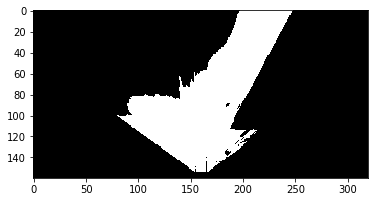

In [6]:
# Identify pixels above the threshold
# Threshold of RGB > 160 does a nice job of identifying ground pixels only
def color_thresh(img, rgb_thresh=(160, 160, 160)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all three threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    above_thresh = (img[:,:,0] > rgb_thresh[0]) \
                & (img[:,:,1] > rgb_thresh[1]) \
                & (img[:,:,2] > rgb_thresh[2])
    # Index the array of zeros with the boolean array and set to 1
    color_select[above_thresh] = 1
    # Return the binary image
    return color_select

threshed = color_thresh(warped)
plt.imshow(threshed, cmap='gray')
#scipy.misc.imsave('../output/warped_threshed.jpg', threshed*255)
scipy.misc.imsave('../output/warped_threshed.jpg', threshed*255)

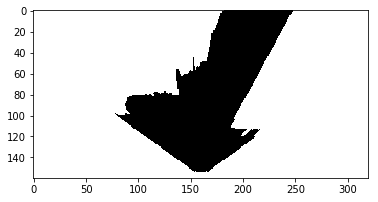

In [7]:
def color_thresh_obstacle(img, rgb_thresh=(160, 160, 160)):
    obstacle_select = np.zeros_like(img[:,:,0])
    
    below_thresh = (img[:,:,0] < rgb_thresh[0]) \
                & (img[:,:,1] < rgb_thresh[1]) \
                & (img[:,:,2] < rgb_thresh[2])
   
    obstacle_select[below_thresh] = 1
    return obstacle_select

thresh_obstacles = color_thresh_obstacle(warped)
plt.imshow(thresh_obstacles, cmap='gray')

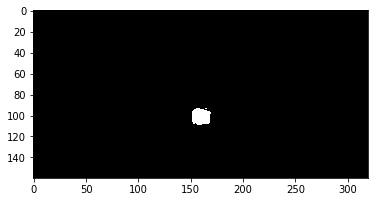

In [8]:
def color_rock_thresh(img, low_rgb_thresh=(100, 100, 0), high_rgb_thresh=(200, 200, 50)):
    
    color_select = np.zeros_like(img[:,:,0])
    rock_select = cv2.inRange(img, low_rgb_thresh, high_rgb_thresh)
    return rock_select

thresh_rocks = color_rock_thresh(rock_img)
plt.imshow(thresh_rocks, cmap='gray')

## Coordinate Transformations
Define the functions used to do coordinate transforms and apply them to an image.

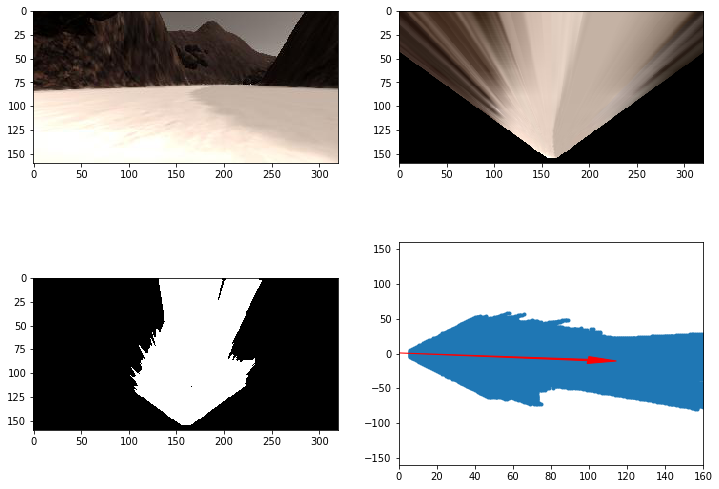

In [9]:
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position being at the 
    # center bottom of the image.  
    x_pixel = -(ypos - binary_img.shape[0]).astype(np.float)
    y_pixel = -(xpos - binary_img.shape[1]/2).astype(np.float)
    return x_pixel, y_pixel

# Define a function to convert to radial coords in rover space
def to_polar_coords(x_pixel, y_pixel):
    # Convert (x_pixel, y_pixel) to (distance, angle) 
    # in polar coordinates in rover space
    # Calculate distance to each pixel
    dist = np.sqrt(x_pixel**2 + y_pixel**2)
    # Calculate angle away from vertical for each pixel
    angles = np.arctan2(y_pixel, x_pixel)
    return dist, angles

# Define a function to apply a rotation to pixel positions
def rotate_pix(xpix, ypix, yaw):
    # TODO:
    # Convert yaw to radians
    yaw_rad = yaw * np.pi/180
    # Apply a rotation
    xpix_rotated = (xpix *np.cos(yaw_rad)) - (ypix * np.sin(yaw_rad))
    ypix_rotated = (ypix *np.cos(yaw_rad)) + (xpix * np.sin(yaw_rad))
    # Return the result  
    return xpix_rotated, ypix_rotated

# Define a function to perform a translation
def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # TODO:
    # Apply a scaling and a translation
    xpix_translated = xpos + (xpix_rot/scale)
    ypix_translated = ypos + (ypix_rot/scale)
    # Return the result  
    return xpix_translated, ypix_translated

# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Perform rotation, translation and clipping all at once
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world

# Grab another random image
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
warped = perspect_transform(image, source, destination)
threshed = color_thresh(warped)

# Calculate pixel values in rover-centric coords and distance/angle to all pixels
xpix, ypix = rover_coords(threshed)
dist, angles = to_polar_coords(xpix, ypix)
mean_dir = np.mean(angles)

# Do some plotting
fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(image)
plt.subplot(222)
plt.imshow(warped)
plt.subplot(223)
plt.imshow(threshed, cmap='gray')
plt.subplot(224)
plt.plot(xpix, ypix, '.')
plt.ylim(-160, 160)
plt.xlim(0, 160)
arrow_length = 100
x_arrow = arrow_length * np.cos(mean_dir)
y_arrow = arrow_length * np.sin(mean_dir)
plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, head_width=10, width=2)



## Read in saved data and ground truth map of the world
The next cell is all setup to read your saved data into a `pandas` dataframe.  Here you'll also read in a "ground truth" map of the world, where white pixels (pixel value = 1) represent navigable terrain.  

After that, we'll define a class to store telemetry data and pathnames to images.  When you instantiate this class (`data = Databucket()`) you'll have a global variable called `data` that you can refer to for telemetry and map data within the `process_image()` function in the following cell.  


In [10]:
# Import pandas and read in csv file as a dataframe
import pandas as pd
# Change the path below to your data directory
# If you are in a locale (e.g., Europe) that uses ',' as the decimal separator
# change the '.' to ','
df = pd.read_csv('../automode_img_data/robot_log.csv', delimiter=',', decimal='.')
csv_img_list = df["Path"].tolist() # Create list of image pathnames
# Read in ground truth map and create a 3-channel image with it
ground_truth = mpimg.imread('../calibration_images/map_bw.png')
ground_truth_3d = np.dstack((ground_truth*0, ground_truth*255, ground_truth*0)).astype(np.float)

# Creating a class to be the data container
# Will read in saved data from csv file and populate this object
# Worldmap is instantiated as 200 x 200 grids corresponding 
# to a 200m x 200m space (same size as the ground truth map: 200 x 200 pixels)
# This encompasses the full range of output position values in x and y from the sim
class Databucket():
    def __init__(self):
        self.images = csv_img_list  
        self.xpos = df["X_Position"].values
        self.ypos = df["Y_Position"].values
        self.yaw = df["Yaw"].values
        self.count = -1 # This will be a running index, setting to -1 is a hack
                        # because moviepy (below) seems to run one extra iteration
        self.worldmap = np.zeros((200, 200, 3)).astype(np.float)
        self.ground_truth = ground_truth_3d # Ground truth worldmap

# Instantiate a Databucket().. this will be a global variable/object
# that you can refer to in the process_image() function below
data = Databucket()


## Write a function to process stored images

Modify the `process_image()` function below by adding in the perception step processes (functions defined above) to perform image analysis and mapping.  The following cell is all set up to use this `process_image()` function in conjunction with the `moviepy` video processing package to create a video from the images you saved taking data in the simulator.  

In short, you will be passing individual images into `process_image()` and building up an image called `output_image` that will be stored as one frame of video.  You can make a mosaic of the various steps of your analysis process and add text as you like (example provided below).  



To start with, you can simply run the next three cells to see what happens, but then go ahead and modify them such that the output video demonstrates your mapping process.  Feel free to get creative!

In [11]:

# Define a function to pass stored images to
# reading rover position and yaw angle from csv file
# This function will be used by moviepy to create an output video
def process_image(img):
    # Example of how to use the Databucket() object defined above
    # to print the current x, y and yaw values 
    # print(data.xpos[data.count], data.ypos[data.count], data.yaw[data.count])
    
    print(data.xpos[data.count], data.ypos[data.count], data.yaw[data.count])
    
    # TODO: 
    
   # 1) Define source and destination points for perspective transform
    dst_size = 5 
    bottom_offset = 6
    source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
    destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                  [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                  ])
    
      
    # 2) Apply perspective transform
    warped = perspect_transform(image, source, destination)
    # 3) Apply color threshold to identify navigable terrain/obstacles/rock samples
    thresh_terrain = color_thresh(warped, rgb_thresh=(160, 160, 160))
    thresh_rocks = color_thresh(warped, rgb_thresh=(100,100,100))
    thresh_obstacles = color_thresh(warped, rgb_thresh=(90, 90, 90))
    # 4) Convert thresholded image pixel values to rover-centric coords
    terrain_xpix, terrain_ypix = rover_coords(thresh_terrain)
    obstacles_xpix, obstacles_ypix = rover_coords(thresh_obstacles)
    rocks_xpix, rocks_ypix = rover_coords(thresh_rocks)
    
    # 5) Convert rover-centric pixel values to world coords
    
    scale = 10
    navigable_x_world, navigable_y_world = pix_to_world(terrain_xpix, terrain_ypix, data.xpos[0], data.ypos[1], data.yaw[0], 200, scale)
    obstacle_x_world, obstacle_y_world = pix_to_world(obstacles_xpix, obstacles_ypix, data.xpos[0], data.ypos[1], data.yaw[0], 200, scale)
    rock_x_world, rock_y_world = pix_to_world(rocks_xpix, rocks_ypix, data.xpos[0], data.ypos[1], data.yaw[0], 200, scale)
    
    
    # 6) Update worldmap (to be displayed on right side of screen)
        # Example: data.worldmap[obstacle_y_world, obstacle_x_world, 0] += 1
        #          data.worldmap[rock_y_world, rock_x_world, 1] += 1
        #          data.worldmap[navigable_y_world, navigable_x_world, 2] += 1
    data.worldmap[obstacle_y_world, obstacle_x_world, 0] += 1
    data.worldmap[rock_y_world, rock_x_world, 1] += 1
    data.worldmap[navigable_y_world, navigable_x_world, 2] += 1
    
    # 7) Make a mosaic image, below is some example code
        # First create a blank image (can be whatever shape you like)
    output_image = np.zeros((img.shape[0] + data.worldmap.shape[0], img.shape[1]*2, 3))
        # Next you can populate regions of the image with various output
        # Here I'm putting the original image in the upper left hand corner
    output_image[0:img.shape[0], 0:img.shape[1]] = img

        # Let's create more images to add to the mosaic, first a warped image
    warped = perspect_transform(img, source, destination)
        # Add the warped image in the upper right hand corner
    output_image[0:img.shape[0], img.shape[1]:] = warped

        # Overlay worldmap with ground truth map
    map_add = cv2.addWeighted(data.worldmap, 1, data.ground_truth, 0.5, 0)
        # Flip map overlay so y-axis points upward and add to output_image 
    output_image[img.shape[0]:, 0:data.worldmap.shape[1]] = np.flipud(map_add)


        # Then putting some text over the image
    cv2.putText(output_image,"Populate this image with your analyses to make a video!", (20, 20), 
                cv2.FONT_HERSHEY_COMPLEX, 0.4, (255, 255, 255), 1)
    
    data.count += 1 # Keep track of the index in the Databucket()
    
    return output_image

## Make a video from processed image data
Use the [moviepy](https://zulko.github.io/moviepy/) library to process images and create a video.
  

In [13]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from moviepy.editor import ImageSequenceClip


# Define pathname to save the output video
output = '../output/mapping.mp4'
data = Databucket() # Re-initialize data in case you're running this cell multiple times
clip = ImageSequenceClip(data.images, fps=25) # Note: output video will be sped up because 
                                          # recording rate in simulator is fps=25
new_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time new_clip.write_videofile(output, audio=False)

108.1031 161.0163 109.181
[MoviePy] >>>> Building video ../output/mapping.mp4
[MoviePy] Writing video ../output/mapping.mp4


  0%|                                                  | 0/261 [00:00<?, ?it/s]

99.66999 85.58897 56.82556


  0%|▏                                         | 1/261 [00:00<00:44,  5.85it/s]

99.66999 85.58897 56.82556
99.66999 85.58897 56.82556


  1%|▍                                         | 3/261 [00:00<00:38,  6.75it/s]

99.66999 85.58897 56.82556


  2%|▋                                         | 4/261 [00:00<00:34,  7.36it/s]

99.66999 85.58897 56.82556


  2%|▊                                         | 5/261 [00:00<00:33,  7.72it/s]

99.66999 85.58897 56.82556
99.66999 85.58897 56.82556


  3%|█▏                                        | 7/261 [00:00<00:29,  8.62it/s]

99.66999 85.58897 56.82556


  3%|█▎                                        | 8/261 [00:00<00:28,  8.75it/s]

99.66999 85.58897 56.82556


  3%|█▍                                        | 9/261 [00:00<00:29,  8.62it/s]

99.66999 85.58897 56.82556
99.66999 85.58897 56.82556


  4%|█▋                                       | 11/261 [00:01<00:27,  9.10it/s]

99.66999 85.58897 56.82556


  5%|█▉                                       | 12/261 [00:01<00:26,  9.28it/s]

99.66999 85.58897 56.82556


  5%|██                                       | 13/261 [00:01<00:27,  9.09it/s]

99.66999 85.58897 56.82556
99.66999 85.58897 56.82556


  6%|██▎                                      | 15/261 [00:01<00:26,  9.45it/s]

99.66999 85.58897 56.82556
99.66999 85.58897 56.82556


  7%|██▋                                      | 17/261 [00:01<00:25,  9.56it/s]

99.66999 85.58897 56.82556


  7%|██▊                                      | 18/261 [00:01<00:25,  9.39it/s]

99.66999 85.58897 56.82556


  7%|██▉                                      | 19/261 [00:02<00:26,  9.17it/s]

99.67377 85.59476 56.69434


  8%|███▏                                     | 20/261 [00:02<00:26,  9.07it/s]

99.68285 85.60847 56.59358
99.72584 85.67291 56.12317


  8%|███▍                                     | 22/261 [00:02<00:25,  9.52it/s]

99.73696 85.68974 56.1423
99.80528 85.79152 56.53549


  9%|███▊                                     | 24/261 [00:02<00:24,  9.74it/s]

99.83376 85.8342 56.43197


 10%|███▉                                     | 25/261 [00:02<00:25,  9.32it/s]

99.86491 85.88072 56.34733
99.91739 85.95893 56.38878


 10%|████▏                                    | 27/261 [00:02<00:24,  9.63it/s]

99.9772 86.04824 56.4589
100.0432 86.1469 56.44115


 11%|████▌                                    | 29/261 [00:03<00:23,  9.82it/s]

100.1283 86.27407 56.35737


 11%|████▋                                    | 30/261 [00:03<00:23,  9.82it/s]

100.2082 86.39313 56.28543
100.2945 86.52133 56.24359


 12%|█████                                    | 32/261 [00:03<00:22, 10.09it/s]

100.3873 86.65908 56.20285
100.4866 86.8061 56.1759


 13%|█████▎                                   | 34/261 [00:03<00:21, 10.40it/s]

100.6104 86.9893 56.15037
100.7285 87.15189 54.97709


 14%|█████▋                                   | 36/261 [00:03<00:22, 10.07it/s]

100.8626 87.31406 52.4484
101.2159 87.71494 48.46639


 15%|█████▉                                   | 38/261 [00:03<00:22,  9.80it/s]

101.2972 87.80679 48.23417


 15%|██████▏                                  | 39/261 [00:04<00:23,  9.60it/s]

101.381 87.90086 48.20402
101.5273 88.0586 47.65556


 16%|██████▍                                  | 41/261 [00:04<00:22,  9.94it/s]

101.8134 88.34058 44.89476
102.0626 88.54672 40.61866


 16%|██████▊                                  | 43/261 [00:04<00:22,  9.84it/s]

102.2949 88.71127 36.6597


 17%|██████▉                                  | 44/261 [00:04<00:22,  9.55it/s]

102.542 88.87274 33.82438


 17%|███████                                  | 45/261 [00:04<00:22,  9.59it/s]

102.802 89.03734 32.39437
103.0743 89.20966 32.14514


 18%|███████▍                                 | 47/261 [00:04<00:21,  9.86it/s]

103.3577 89.38921 32.16206


 18%|███████▌                                 | 48/261 [00:04<00:22,  9.29it/s]

103.7011 89.60674 32.20214


 19%|███████▋                                 | 49/261 [00:05<00:23,  9.05it/s]

104.0054 89.7999 32.25035
104.3163 89.99292 32.23031


 20%|████████                                 | 51/261 [00:05<00:22,  9.25it/s]

104.6856 90.22285 32.20723
105.0052 90.43465 33.62556


 20%|████████▎                                | 53/261 [00:05<00:21,  9.53it/s]

105.316 90.66675 36.93213


 21%|████████▍                                | 54/261 [00:05<00:22,  9.29it/s]

105.6592 90.96861 42.05804


 21%|████████▋                                | 55/261 [00:05<00:22,  9.33it/s]

105.9375 91.2532 46.35458


 21%|████████▊                                | 56/261 [00:05<00:21,  9.36it/s]

106.3129 91.67197 50.06318


 22%|████████▉                                | 57/261 [00:05<00:21,  9.52it/s]

106.633 92.06561 51.57302


 22%|█████████                                | 58/261 [00:05<00:21,  9.39it/s]

106.9108 92.41568 51.7729


 23%|█████████▎                               | 59/261 [00:06<00:21,  9.45it/s]

107.1471 92.71313 51.73979
107.4254 93.08021 52.90674


 23%|█████████▌                               | 61/261 [00:06<00:20,  9.81it/s]

107.7054 93.4522 53.3378


 24%|█████████▋                               | 62/261 [00:06<00:20,  9.64it/s]

108.0398 93.89678 53.31834


 24%|█████████▉                               | 63/261 [00:06<00:21,  9.08it/s]

108.3894 94.34438 51.72805


 25%|██████████                               | 64/261 [00:06<00:21,  8.98it/s]

108.6551 94.65695 49.20832
108.9965 95.01253 44.8268


 25%|██████████▎                              | 66/261 [00:06<00:20,  9.37it/s]

109.4924 95.44886 38.8239
109.8975 95.76476 35.01863


 26%|██████████▋                              | 68/261 [00:07<00:20,  9.47it/s]

110.33 96.06069 31.32415


 26%|██████████▊                              | 69/261 [00:07<00:21,  8.76it/s]

110.7861 96.32956 29.08929


 27%|██████████▉                              | 70/261 [00:07<00:22,  8.43it/s]

111.1774 96.54853 28.5888


 27%|███████████▏                             | 71/261 [00:07<00:22,  8.40it/s]

111.6593 96.80494 27.50987
112.1552 97.04578 25.01688


 28%|███████████▍                             | 73/261 [00:07<00:21,  8.68it/s]

112.5781 97.2364 23.33287


 28%|███████████▌                             | 74/261 [00:07<00:22,  8.25it/s]

113.0996 97.46294 22.75098


 29%|███████████▊                             | 75/261 [00:07<00:21,  8.55it/s]

113.6294 97.68782 22.68317


 29%|███████████▉                             | 76/261 [00:07<00:21,  8.42it/s]

114.2505 97.9487 22.68373


 30%|████████████                             | 77/261 [00:08<00:23,  7.79it/s]

114.7797 98.17036 22.68864


 30%|████████████▎                            | 78/261 [00:08<00:22,  8.18it/s]

115.2996 98.39793 23.75486
115.7282 98.58889 24.29935


 31%|████████████▌                            | 80/261 [00:08<00:21,  8.56it/s]

116.2402 98.8177 24.40376


 31%|████████████▋                            | 81/261 [00:08<00:21,  8.36it/s]

116.7488 99.04632 24.38921


 31%|████████████▉                            | 82/261 [00:08<00:21,  8.29it/s]

117.1706 99.2359 24.36494
117.674 99.4624 24.33884


 32%|█████████████▏                           | 84/261 [00:08<00:21,  8.24it/s]

118.1734 99.68747 24.32234
118.5865 99.87412 24.31747


 33%|█████████████▌                           | 86/261 [00:09<00:19,  8.96it/s]

119.0789 100.0965 24.31053


 33%|█████████████▋                           | 87/261 [00:09<00:19,  8.81it/s]

119.5684 100.318 24.30814


 34%|█████████████▊                           | 88/261 [00:09<00:19,  8.75it/s]

120.6182 100.7946 24.34953


 34%|█████████████▉                           | 89/261 [00:09<00:20,  8.55it/s]

121.0874 101.0301 26.81537


 34%|██████████████▏                          | 90/261 [00:09<00:20,  8.51it/s]

121.3165 101.1564 28.64836


 35%|██████████████▎                          | 91/261 [00:09<00:20,  8.31it/s]

121.5431 101.2888 30.53949


 35%|██████████████▍                          | 92/261 [00:09<00:21,  8.00it/s]

121.9131 101.5205 33.94146


 36%|██████████████▌                          | 93/261 [00:09<00:21,  7.83it/s]

122.3253 101.8146 38.34183


 36%|██████████████▊                          | 94/261 [00:10<00:20,  8.01it/s]

122.7084 102.1386 42.74102
123.06 102.4884 47.09498


 37%|███████████████                          | 96/261 [00:10<00:19,  8.52it/s]

123.3277 102.7974 50.70763


 37%|███████████████▏                         | 97/261 [00:10<00:20,  8.17it/s]

123.6635 103.2538 55.78267


 38%|███████████████▍                         | 98/261 [00:10<00:20,  8.14it/s]

123.9927 103.8007 61.57471
124.2294 104.2989 66.6756


 38%|███████████████▎                        | 100/261 [00:10<00:19,  8.47it/s]

124.4264 104.8079 70.29623


 39%|███████████████▍                        | 101/261 [00:10<00:18,  8.67it/s]

124.5539 105.1738 71.4998
124.7737 105.8304 71.83766


 39%|███████████████▊                        | 103/261 [00:11<00:17,  9.08it/s]

124.9404 106.336 71.83766


 40%|███████████████▉                        | 104/261 [00:11<00:17,  8.96it/s]

125.105 106.8367 71.83145


 40%|████████████████                        | 105/261 [00:11<00:18,  8.49it/s]

125.2448 107.2624 71.82616


 41%|████████████████▏                       | 106/261 [00:11<00:19,  8.00it/s]

125.4746 107.9666 71.84336


 41%|████████████████▍                       | 107/261 [00:11<00:19,  8.06it/s]

125.6818 108.5172 68.88197


 41%|████████████████▌                       | 108/261 [00:11<00:18,  8.34it/s]

125.8958 108.9879 64.62962


 42%|████████████████▋                       | 109/261 [00:11<00:17,  8.47it/s]

126.0895 109.3705 61.34893


 42%|████████████████▊                       | 110/261 [00:11<00:18,  8.18it/s]

126.2626 109.677 60.00617


 43%|█████████████████                       | 111/261 [00:12<00:17,  8.37it/s]

126.4741 110.044 59.67871


 43%|█████████████████▏                      | 112/261 [00:12<00:18,  8.25it/s]

126.6779 110.4114 60.7897


 43%|█████████████████▎                      | 113/261 [00:12<00:17,  8.42it/s]

126.9207 110.9101 64.51556
127.1079 111.3594 69.04601


 44%|█████████████████▌                      | 115/261 [00:12<00:16,  9.12it/s]

127.2375 111.7401 73.37734


 44%|█████████████████▊                      | 116/261 [00:12<00:16,  9.06it/s]

127.3134 112.0652 76.84841


 45%|█████████████████▉                      | 117/261 [00:12<00:16,  8.65it/s]

127.38 112.4562 81.17818


 45%|██████████████████                      | 118/261 [00:12<00:17,  8.21it/s]

127.4134 112.8462 85.51775


 46%|██████████████████▏                     | 119/261 [00:13<00:17,  7.93it/s]

127.4169 113.2985 90.51855


 46%|██████████████████▍                     | 120/261 [00:13<00:16,  8.39it/s]

127.3941 113.6173 94.10825
127.3415 113.9938 98.3808


 47%|██████████████████▋                     | 122/261 [00:13<00:15,  9.21it/s]

127.2762 114.3009 101.9451


 47%|██████████████████▊                     | 123/261 [00:13<00:15,  8.67it/s]

127.18 114.6624 105.2077
127.0718 115.0183 107.0244


 48%|███████████████████▏                    | 125/261 [00:13<00:15,  8.97it/s]

126.9807 115.3127 107.3842


 48%|███████████████████▎                    | 126/261 [00:13<00:14,  9.03it/s]

126.8717 115.6628 107.4123


 49%|███████████████████▍                    | 127/261 [00:13<00:14,  8.95it/s]

126.763 116.0099 107.4124


 49%|███████████████████▌                    | 128/261 [00:13<00:14,  9.12it/s]

126.6731 116.297 107.4096
126.5477 116.696 107.4107


 50%|███████████████████▉                    | 130/261 [00:14<00:14,  9.02it/s]

126.4406 117.0362 107.4121
126.3334 117.3749 107.4302


 51%|████████████████████▏                   | 132/261 [00:14<00:13,  9.22it/s]

126.2447 117.6558 107.4398


 51%|████████████████████▍                   | 133/261 [00:14<00:14,  8.79it/s]

126.1214 118.0468 107.4467


 51%|████████████████████▌                   | 134/261 [00:14<00:14,  8.52it/s]

125.9991 118.4347 107.4553


 52%|████████████████████▋                   | 135/261 [00:14<00:14,  8.70it/s]

125.8843 118.7601 108.9222
125.7756 119.0242 111.4108


 52%|████████████████████▉                   | 137/261 [00:14<00:13,  9.22it/s]

125.6271 119.3334 115.2308


 53%|█████████████████████▏                  | 138/261 [00:15<00:13,  9.10it/s]

125.4684 119.6293 119.3294
125.2215 119.9877 124.6004


 54%|█████████████████████▍                  | 140/261 [00:15<00:12,  9.52it/s]

125.0142 120.2411 128.5941


 54%|█████████████████████▌                  | 141/261 [00:15<00:13,  8.98it/s]

124.7939 120.4752 132.6657


 54%|█████████████████████▊                  | 142/261 [00:15<00:13,  8.96it/s]

124.5596 120.6914 136.6873


 55%|█████████████████████▉                  | 143/261 [00:15<00:13,  8.63it/s]

124.2705 120.9194 141.3506


 55%|██████████████████████                  | 144/261 [00:15<00:13,  8.41it/s]

124.0583 121.0711 143.7796


 56%|██████████████████████▏                 | 145/261 [00:15<00:14,  8.22it/s]

123.7587 121.2769 145.3436


 56%|██████████████████████▍                 | 146/261 [00:15<00:13,  8.27it/s]

123.5465 121.4226 145.5704


 56%|██████████████████████▌                 | 147/261 [00:16<00:13,  8.23it/s]

123.2981 121.6018 144.664


 57%|██████████████████████▋                 | 148/261 [00:16<00:13,  8.22it/s]

123.1 121.7585 142.8245


 57%|██████████████████████▊                 | 149/261 [00:16<00:13,  8.11it/s]

122.8749 121.9596 139.3113


 57%|██████████████████████▉                 | 150/261 [00:16<00:13,  8.04it/s]

122.6575 122.1722 135.6121


 58%|███████████████████████▏                | 151/261 [00:16<00:13,  7.86it/s]

122.433 122.4272 131.1479


 58%|███████████████████████▎                | 152/261 [00:16<00:13,  7.92it/s]

122.2366 122.7035 126.6269


 59%|███████████████████████▍                | 153/261 [00:16<00:14,  7.69it/s]

122.0857 122.9489 122.7649


 59%|███████████████████████▌                | 154/261 [00:16<00:13,  7.71it/s]

121.9533 123.2007 118.948


 59%|███████████████████████▊                | 155/261 [00:17<00:13,  7.77it/s]

121.8391 123.4586 115.1397


 60%|███████████████████████▉                | 156/261 [00:17<00:13,  7.90it/s]

121.7583 123.6778 111.9805


 60%|████████████████████████                | 157/261 [00:17<00:12,  8.04it/s]

121.6665 123.9874 107.5734


 61%|████████████████████████▏               | 158/261 [00:17<00:12,  8.33it/s]

121.6103 124.21 105.3347


 61%|████████████████████████▎               | 159/261 [00:17<00:12,  8.17it/s]

121.5267 124.565 103.6129


 61%|████████████████████████▌               | 160/261 [00:17<00:12,  8.06it/s]

121.4535 124.8722 103.4063


 62%|████████████████████████▋               | 161/261 [00:17<00:12,  8.00it/s]

121.4016 125.09 103.4027


 62%|████████████████████████▊               | 162/261 [00:17<00:12,  8.08it/s]

121.3317 125.347 104.5098


 62%|████████████████████████▉               | 163/261 [00:18<00:11,  8.19it/s]

121.2496 125.5987 106.8619


 63%|█████████████████████████▏              | 164/261 [00:18<00:12,  8.04it/s]

121.1691 125.8046 109.6445


 63%|█████████████████████████▎              | 165/261 [00:18<00:11,  8.03it/s]

121.0628 126.0463 113.1196


 64%|█████████████████████████▍              | 166/261 [00:18<00:11,  8.11it/s]

120.9489 126.2728 115.7412


 64%|█████████████████████████▌              | 167/261 [00:18<00:11,  7.91it/s]

120.8508 126.4594 116.8842


 64%|█████████████████████████▋              | 168/261 [00:18<00:11,  7.82it/s]

120.7361 126.6834 117.0822


 65%|█████████████████████████▉              | 169/261 [00:18<00:11,  7.88it/s]

120.6219 126.9063 117.088


 65%|██████████████████████████              | 170/261 [00:18<00:11,  7.91it/s]

120.5218 127.0882 117.9225


 66%|██████████████████████████▏             | 171/261 [00:19<00:11,  7.98it/s]

120.391 127.2988 120.1851


 66%|██████████████████████████▎             | 172/261 [00:19<00:12,  7.38it/s]

120.2134 127.5768 122.0067
120.0608 127.8194 122.2032


 67%|██████████████████████████▋             | 174/261 [00:19<00:11,  7.75it/s]

119.94 128.0305 120.8659


 67%|██████████████████████████▊             | 175/261 [00:19<00:11,  7.79it/s]

119.8338 128.2458 118.2084
119.731 128.4622 116.3708


 68%|███████████████████████████▏            | 177/261 [00:19<00:10,  8.20it/s]

119.6444 128.6422 115.785


 68%|███████████████████████████▎            | 178/261 [00:19<00:10,  8.30it/s]

119.5409 128.8555 115.7111


 69%|███████████████████████████▍            | 179/261 [00:20<00:10,  8.01it/s]

119.4561 129.0308 115.7131


 69%|███████████████████████████▌            | 180/261 [00:20<00:10,  7.86it/s]

119.339 129.2734 115.7129


 69%|███████████████████████████▋            | 181/261 [00:20<00:09,  8.31it/s]

119.2483 129.4822 114.5046


 70%|███████████████████████████▉            | 182/261 [00:20<00:09,  8.69it/s]

119.1827 129.6585 112.5506
119.1061 129.8699 110.9834


 70%|████████████████████████████▏           | 184/261 [00:20<00:08,  9.18it/s]

119.0282 130.0794 110.5562


 71%|████████████████████████████▎           | 185/261 [00:20<00:08,  9.28it/s]

118.9632 130.2527 110.5155


 71%|████████████████████████████▌           | 186/261 [00:20<00:08,  9.15it/s]

118.8846 130.4625 110.5139


 72%|████████████████████████████▋           | 187/261 [00:20<00:08,  8.98it/s]

118.8034 130.6796 110.5143


 72%|████████████████████████████▊           | 188/261 [00:21<00:08,  8.69it/s]

118.7324 130.8695 110.515


 72%|████████████████████████████▉           | 189/261 [00:21<00:08,  8.49it/s]

118.6279 131.1496 110.5179


 73%|█████████████████████████████           | 190/261 [00:21<00:08,  8.62it/s]

118.5369 131.3993 110.4803


 73%|█████████████████████████████▎          | 191/261 [00:21<00:08,  8.62it/s]

118.4444 131.6498 110.4862
118.3474 131.9128 110.4576


 74%|█████████████████████████████▌          | 193/261 [00:21<00:07,  8.99it/s]

118.0717 132.6624 110.3759
117.9991 132.8604 110.3586


 75%|█████████████████████████████▉          | 195/261 [00:21<00:07,  9.32it/s]

117.925 133.0627 110.3427


 75%|██████████████████████████████          | 196/261 [00:21<00:07,  8.77it/s]

117.8111 133.3742 110.3189


 75%|██████████████████████████████▏         | 197/261 [00:22<00:07,  8.54it/s]

117.6937 133.6953 110.2928


 76%|██████████████████████████████▎         | 198/261 [00:22<00:07,  8.41it/s]

117.5732 134.0258 110.2688


 76%|██████████████████████████████▍         | 199/261 [00:22<00:07,  8.47it/s]

117.4702 134.3083 110.2482


 77%|██████████████████████████████▋         | 200/261 [00:22<00:07,  8.52it/s]

117.3437 134.656 110.2203


 77%|██████████████████████████████▊         | 201/261 [00:22<00:07,  8.17it/s]

117.214 135.0129 110.1933


 77%|██████████████████████████████▉         | 202/261 [00:22<00:07,  8.28it/s]

117.0811 135.3792 110.1618
116.9452 135.7545 110.1322


 78%|███████████████████████████████▎        | 204/261 [00:22<00:06,  8.77it/s]

116.7828 136.2039 110.0956


 79%|███████████████████████████████▍        | 205/261 [00:22<00:06,  9.03it/s]

116.6402 136.5989 110.0619


 79%|███████████████████████████████▌        | 206/261 [00:23<00:05,  9.17it/s]

116.4947 137.0029 110.0292


 79%|███████████████████████████████▋        | 207/261 [00:23<00:05,  9.40it/s]

116.3463 137.4159 109.9935


 80%|███████████████████████████████▉        | 208/261 [00:23<00:05,  9.41it/s]

116.2204 137.7668 109.9628
116.0667 138.1959 109.9239


 80%|████████████████████████████████▏       | 210/261 [00:23<00:05, 10.03it/s]

115.9102 138.6339 109.8857
115.751 139.0805 109.8433


 81%|████████████████████████████████▍       | 212/261 [00:23<00:05,  9.48it/s]

115.6162 139.4594 109.8095
115.452 139.9219 109.7648


 82%|████████████████████████████████▊       | 214/261 [00:23<00:04,  9.71it/s]

115.257 140.4724 109.7132


 82%|████████████████████████████████▉       | 215/261 [00:24<00:05,  9.05it/s]

115.0872 140.9533 109.6668


 83%|█████████████████████████████████       | 216/261 [00:24<00:05,  8.73it/s]

114.9148 141.4429 109.6186


 83%|█████████████████████████████████▎      | 217/261 [00:24<00:05,  8.77it/s]

114.7693 141.8571 109.5765


 84%|█████████████████████████████████▍      | 218/261 [00:24<00:04,  8.93it/s]

114.5924 142.362 109.5239


 84%|█████████████████████████████████▌      | 219/261 [00:24<00:05,  8.35it/s]

114.4131 142.8752 109.4725


 84%|█████████████████████████████████▋      | 220/261 [00:24<00:04,  8.78it/s]

114.2326 143.3937 109.4062


 85%|█████████████████████████████████▊      | 221/261 [00:24<00:04,  8.43it/s]

114.0825 143.8261 109.3538


 85%|██████████████████████████████████      | 222/261 [00:24<00:04,  8.40it/s]

113.9043 144.3406 109.2964


 85%|██████████████████████████████████▏     | 223/261 [00:24<00:04,  8.42it/s]

113.7282 144.8492 109.2494


 86%|██████████████████████████████████▎     | 224/261 [00:25<00:04,  8.35it/s]

113.5824 145.2698 109.2269


 86%|██████████████████████████████████▍     | 225/261 [00:25<00:04,  8.35it/s]

113.4081 145.7733 109.195
113.2335 146.2749 109.189


 87%|██████████████████████████████████▊     | 227/261 [00:25<00:03,  8.57it/s]

113.0595 146.7746 109.1919


 87%|██████████████████████████████████▉     | 228/261 [00:25<00:03,  8.26it/s]

112.8866 147.2724 109.1832


 88%|███████████████████████████████████     | 229/261 [00:25<00:03,  8.72it/s]

112.7431 147.685 109.1814
112.5706 148.1778 109.2075


 89%|███████████████████████████████████▍    | 231/261 [00:25<00:03,  9.14it/s]

112.3722 148.7491 109.2008
112.1752 149.3164 109.1837


 89%|███████████████████████████████████▋    | 233/261 [00:26<00:03,  9.28it/s]

112.0075 149.7983 109.1828


 90%|███████████████████████████████████▊    | 234/261 [00:26<00:03,  8.85it/s]

111.8685 150.1975 109.1865


 90%|████████████████████████████████████    | 235/261 [00:26<00:03,  8.53it/s]

111.7028 150.6734 109.1882


 90%|████████████████████████████████████▏   | 236/261 [00:26<00:02,  8.76it/s]

111.5106 151.2239 109.2028
111.3475 151.6923 109.2081


 91%|████████████████████████████████████▍   | 238/261 [00:26<00:02,  9.37it/s]

111.186 152.1579 109.1907
111.0521 152.5428 109.1892


 92%|████████████████████████████████████▊   | 240/261 [00:26<00:02, 10.01it/s]

110.8927 153.0022 109.1731
110.7599 153.3825 109.1844


 93%|█████████████████████████████████████   | 242/261 [00:26<00:01,  9.93it/s]

110.602 153.8358 109.1892
110.4448 154.2859 109.2041


 93%|█████████████████████████████████████▍  | 244/261 [00:27<00:01, 10.07it/s]

110.3151 154.6585 109.2069
110.1607 155.1034 109.1907


 94%|█████████████████████████████████████▋  | 246/261 [00:27<00:01,  9.84it/s]

110.0327 155.4713 109.1893


 95%|█████████████████████████████████████▊  | 247/261 [00:27<00:01,  9.41it/s]

109.8804 155.9106 109.1733


 95%|██████████████████████████████████████  | 248/261 [00:27<00:01,  8.94it/s]

109.7534 156.2741 109.1856


 95%|██████████████████████████████████████▏ | 249/261 [00:27<00:01,  8.37it/s]

109.6024 156.7075 109.1899


 96%|██████████████████████████████████████▎ | 250/261 [00:27<00:01,  8.51it/s]

109.477 157.0663 109.2025


 96%|██████████████████████████████████████▍ | 251/261 [00:27<00:01,  8.29it/s]

109.3282 157.4944 109.2007


 97%|██████████████████████████████████████▌ | 252/261 [00:28<00:01,  8.32it/s]

109.205 157.8492 109.1918


 97%|██████████████████████████████████████▊ | 253/261 [00:28<00:00,  8.63it/s]

109.0582 158.2718 109.1849


 97%|██████████████████████████████████████▉ | 254/261 [00:28<00:00,  8.90it/s]

108.8394 158.9003 109.1823


 98%|███████████████████████████████████████ | 255/261 [00:28<00:00,  9.18it/s]

108.7909 159.0391 109.1877


 98%|███████████████████████████████████████▏| 256/261 [00:28<00:00,  8.61it/s]

108.6466 159.4535 109.1915


 98%|███████████████████████████████████████▍| 257/261 [00:28<00:00,  8.44it/s]

108.5029 159.865 109.2045


 99%|███████████████████████████████████████▌| 258/261 [00:28<00:00,  8.32it/s]

108.361 160.274 109.1952


 99%|███████████████████████████████████████▋| 259/261 [00:28<00:00,  8.50it/s]

108.2198 160.68 109.1917
108.1031 161.0163 109.181


100%|████████████████████████████████████████| 261/261 [00:29<00:00,  8.91it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output/mapping.mp4 

Wall time: 30.4 s


### This next cell should function as an inline video player
If this fails to render the video, try running the following cell (alternative video rendering method).  You can also simply have a look at the saved mp4 in your `/output` folder

In [14]:

from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

### Below is an alternative way to create a video in case the above cell did not work.

In [16]:
import io
import base64
video = io.open(output, 'r+b').read()
encoded_video = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded_video.decode('ascii')))